In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dtype_mapping = {
    "DiagnosisGroupCode": str,
    "DOD": str,
    "ClmAdmitDiagnosisCode": str,
    "ClmDiagnosisCode_1": str,
    "ClmDiagnosisCode_2": str,
    "ClmDiagnosisCode_3": str,
    "ClmDiagnosisCode_4": str,
    "ClmDiagnosisCode_5": str,
    "ClmDiagnosisCode_6": str,
    "ClmDiagnosisCode_7": str,
    "ClmDiagnosisCode_8": str,
    "ClmDiagnosisCode_9": str,
    "ClmDiagnosisCode_10": str
}

date_columns = ["ClaimStartDt", "ClaimEndDt", "DOB", "DOD", "AdmissionDt", "DischargeDt"]

train_data = pd.read_csv("data/train_data.csv", dtype=dtype_mapping, parse_dates=date_columns)
unlabeled_data = pd.read_csv("data/unlabeled_data.csv", dtype=dtype_mapping, parse_dates=date_columns)

date_format = "%Y-%m-%d"

for col in ["AdmissionDt", "DischargeDt", "DOD"]:
    if col in train_data.columns:
        train_data[col] = pd.to_datetime(train_data[col], format=date_format, errors="coerce")
    if col in unlabeled_data.columns:
        unlabeled_data[col] = pd.to_datetime(unlabeled_data[col], format=date_format, errors="coerce")

print("Data loaded")

Data loaded


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 59 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   BeneID                           558211 non-null  object        
 1   ClaimID                          558211 non-null  object        
 2   ClaimStartDt                     558211 non-null  datetime64[ns]
 3   ClaimEndDt                       558211 non-null  datetime64[ns]
 4   Provider                         558211 non-null  object        
 5   InscClaimAmtReimbursed           558211 non-null  int64         
 6   AttendingPhysician               556703 non-null  object        
 7   OperatingPhysician               114447 non-null  object        
 8   OtherPhysician                   199736 non-null  object        
 9   AdmissionDt                      40474 non-null   datetime64[ns]
 10  ClmAdmitDiagnosisCode            145899 non-

In [16]:
train_data.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,ChronicCount,PotentialFraud,ClaimType
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,36000,3204,60,70,82,7,Yes,Inpatient
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,36000,3204,60,70,82,7,No,Inpatient
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,36000,3204,60,70,82,7,No,Inpatient
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,1,5000,1068,250,320,111,6,No,Inpatient
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,2,2,21260,2136,120,100,87,5,No,Inpatient


In [17]:
full_data = pd.concat([train_data, unlabeled_data], axis=0, ignore_index=True)

date_columns = ["ClaimStartDt", "ClaimEndDt", "AdmissionDt", "DischargeDt", "DOB", "DOD"]
for col in date_columns:
    if col in full_data.columns:
        full_data[col] = pd.to_datetime(full_data[col], errors="coerce")

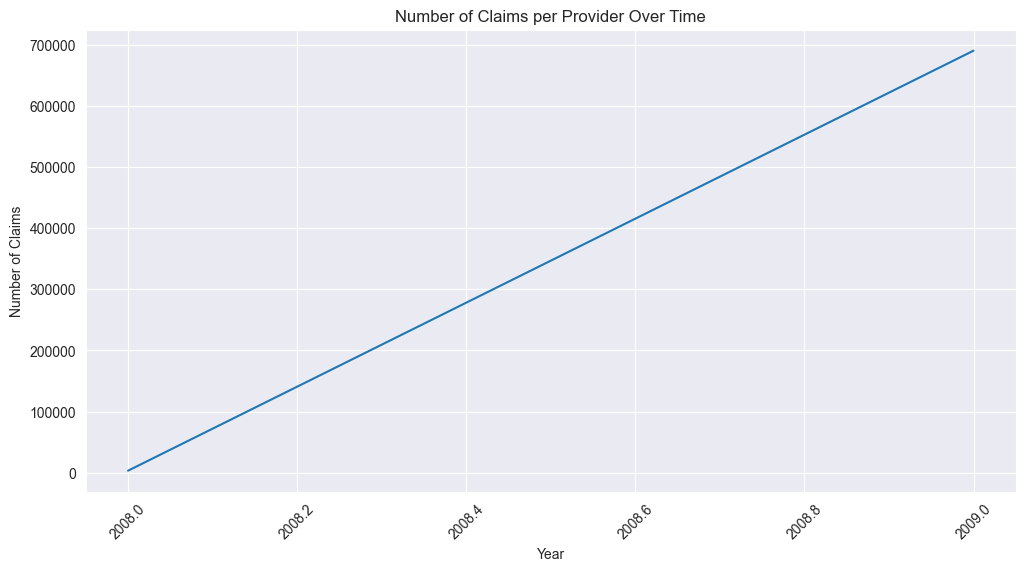

In [18]:
full_data["ClaimYear"] = full_data["ClaimStartDt"].dt.year

claims_per_provider = full_data.groupby(["ClaimYear", "Provider"]).size().reset_index(name="ClaimCount")

plt.figure(figsize=(12, 6))
sns.lineplot(data=claims_per_provider, x="ClaimYear", y="ClaimCount", estimator="sum", errorbar=None)
plt.title("Number of Claims per Provider Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Claims")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

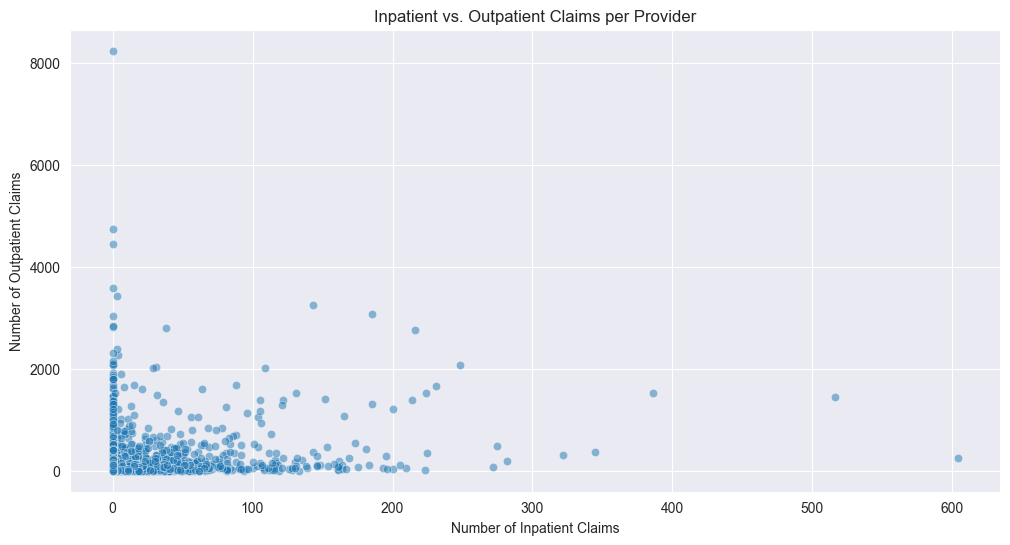

In [20]:
full_data["AdmissionDt"] = pd.to_datetime(full_data["AdmissionDt"], errors="coerce")
full_data["ClaimStartDt"] = pd.to_datetime(full_data["ClaimStartDt"], errors="coerce")

inpatient_counts = full_data[full_data["ClaimType"] == "Inpatient"].groupby("Provider")["AdmissionDt"].count().reset_index()
inpatient_counts.columns = ["Provider", "InpatientClaims"]

outpatient_counts = full_data[full_data["ClaimType"] == "Outpatient"].groupby("Provider")["ClaimStartDt"].count().reset_index()
outpatient_counts.columns = ["Provider", "OutpatientClaims"]

claims_type = pd.merge(inpatient_counts, outpatient_counts, on="Provider", how="outer").fillna(0)

claims_type["InpatientClaims"] = claims_type["InpatientClaims"].astype(int)
claims_type["OutpatientClaims"] = claims_type["OutpatientClaims"].astype(int)

claims_type = claims_type[(claims_type["InpatientClaims"] > 0) | (claims_type["OutpatientClaims"] > 0)]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=claims_type, x="InpatientClaims", y="OutpatientClaims", alpha=0.5)
plt.title("Inpatient vs. Outpatient Claims per Provider")
plt.xlabel("Number of Inpatient Claims")
plt.ylabel("Number of Outpatient Claims")
plt.grid(True)
plt.show()

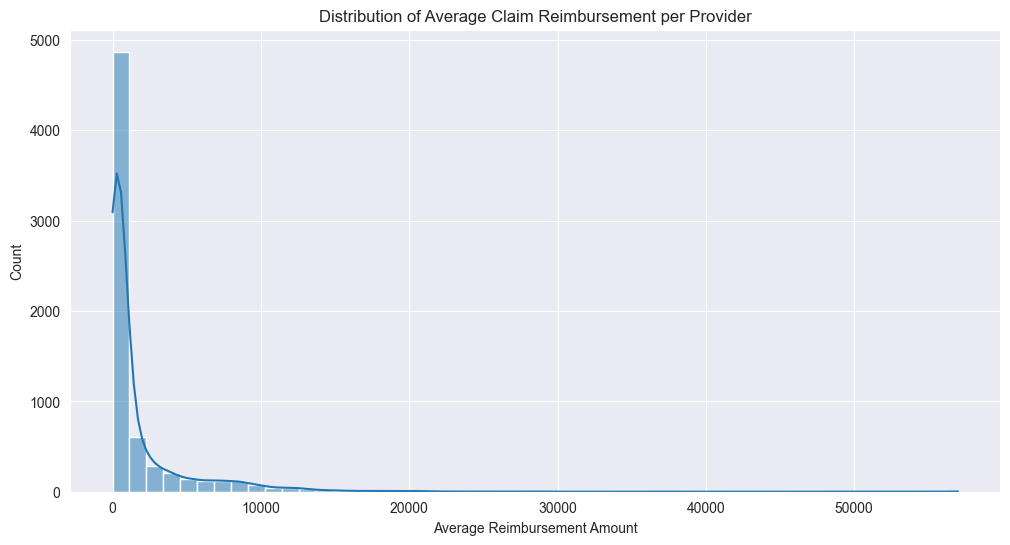

In [21]:
avg_reimbursement = full_data.groupby("Provider")["InscClaimAmtReimbursed"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.histplot(avg_reimbursement["InscClaimAmtReimbursed"], bins=50, kde=True)
plt.title("Distribution of Average Claim Reimbursement per Provider")
plt.xlabel("Average Reimbursement Amount")
plt.ylabel("Count")
plt.grid(True)
plt.show()

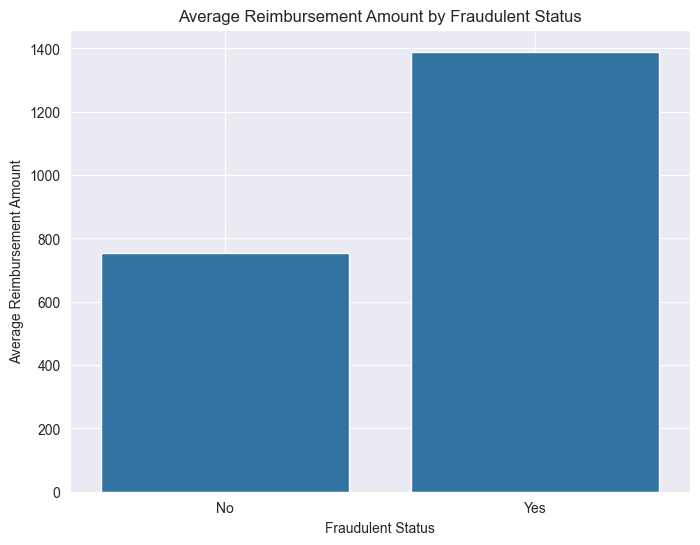

In [22]:
fraud_analysis = train_data.groupby("PotentialFraud")["InscClaimAmtReimbursed"].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=fraud_analysis, x="PotentialFraud", y="InscClaimAmtReimbursed")
plt.title("Average Reimbursement Amount by Fraudulent Status")
plt.xlabel("Fraudulent Status")
plt.ylabel("Average Reimbursement Amount")
plt.grid(True)
plt.show()


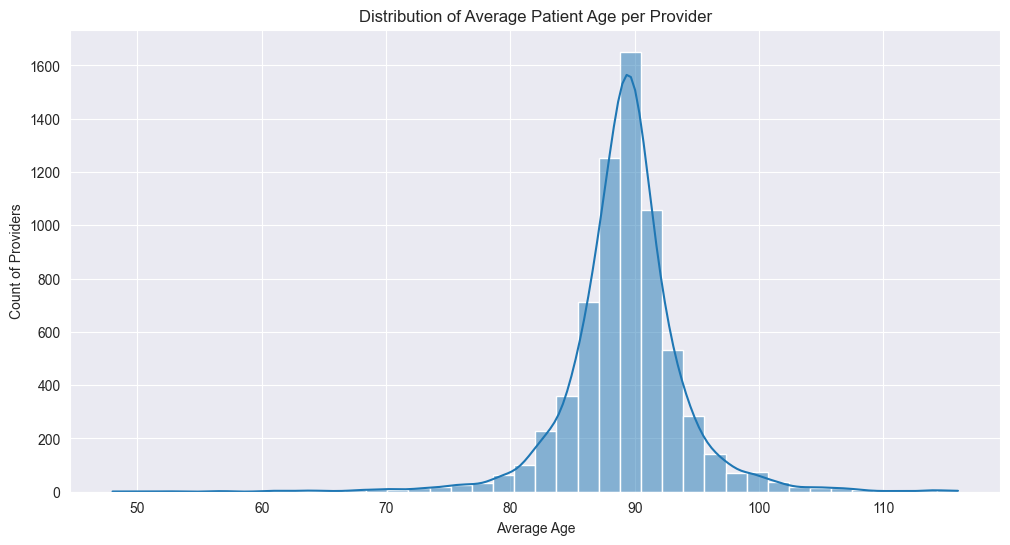

In [23]:
age_per_provider = full_data.groupby("Provider")["Age"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.histplot(age_per_provider["Age"], bins=40, kde=True)
plt.title("Distribution of Average Patient Age per Provider")
plt.xlabel("Average Age")
plt.ylabel("Count of Providers")
plt.grid(True)
plt.show()

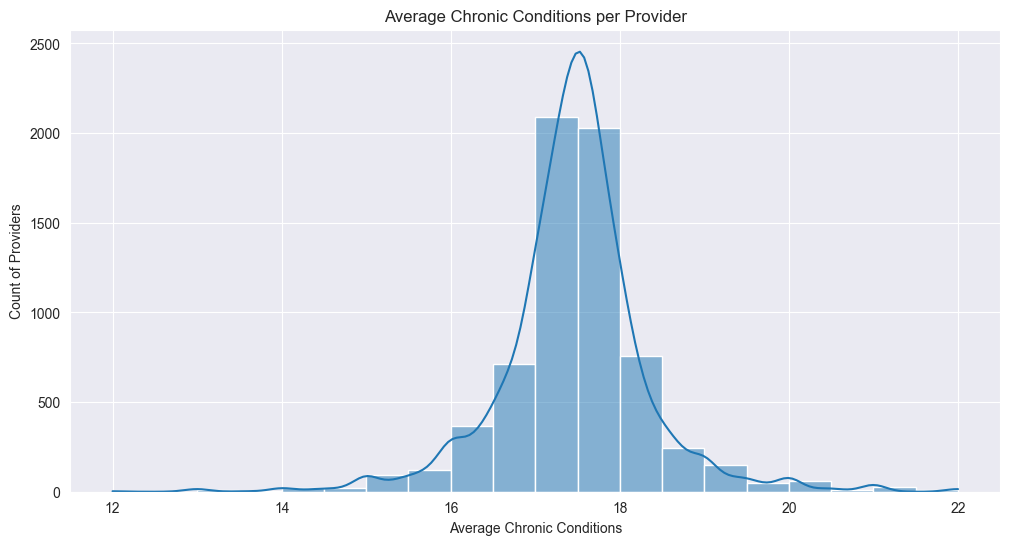

In [24]:
chronic_cols = [col for col in full_data.columns if "ChronicCond" in col]
full_data["ChronicConditionSum"] = full_data[chronic_cols].sum(axis=1)

chronic_per_provider = full_data.groupby("Provider")["ChronicConditionSum"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.histplot(chronic_per_provider["ChronicConditionSum"], bins=20, kde=True)
plt.title("Average Chronic Conditions per Provider")
plt.xlabel("Average Chronic Conditions")
plt.ylabel("Count of Providers")
plt.grid(True)
plt.show()

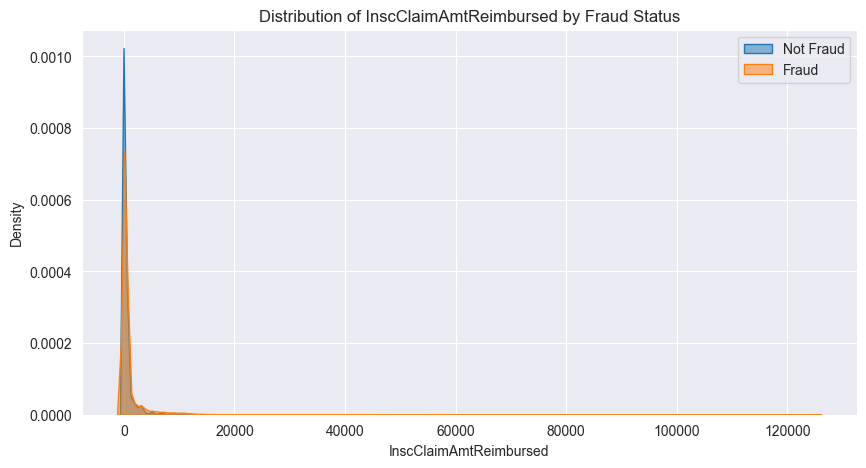

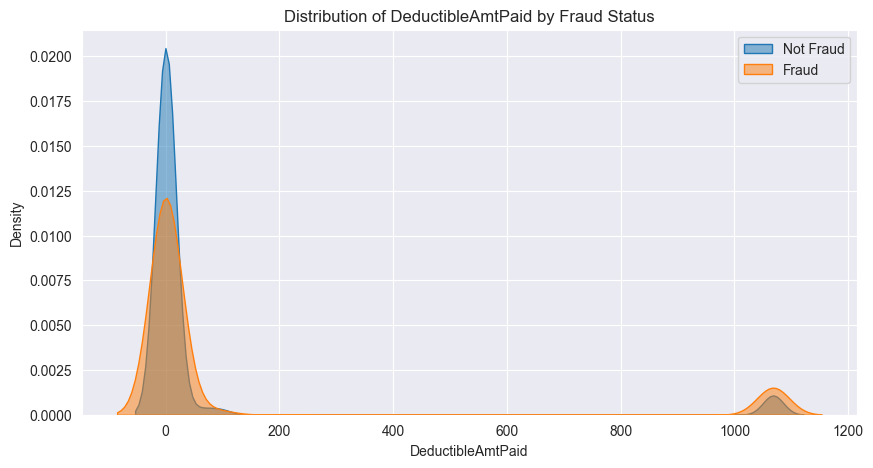

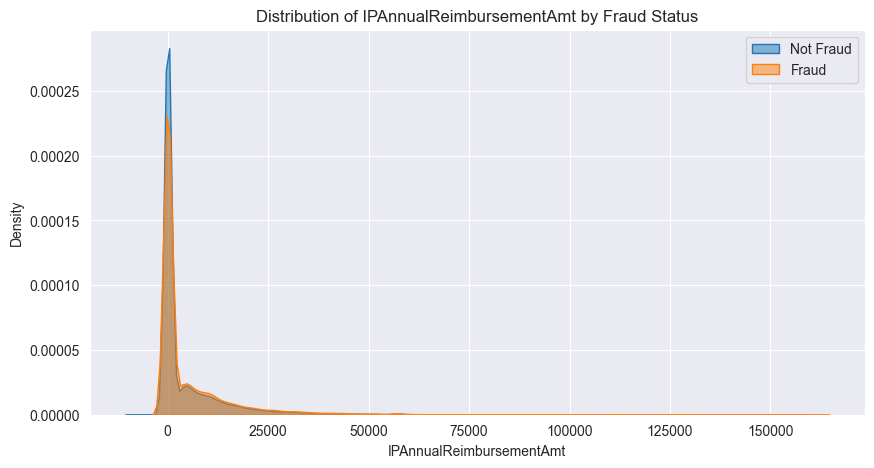

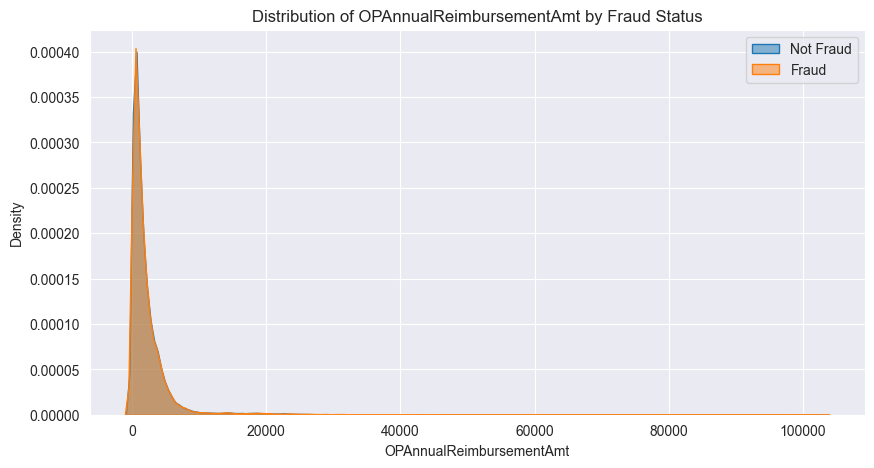

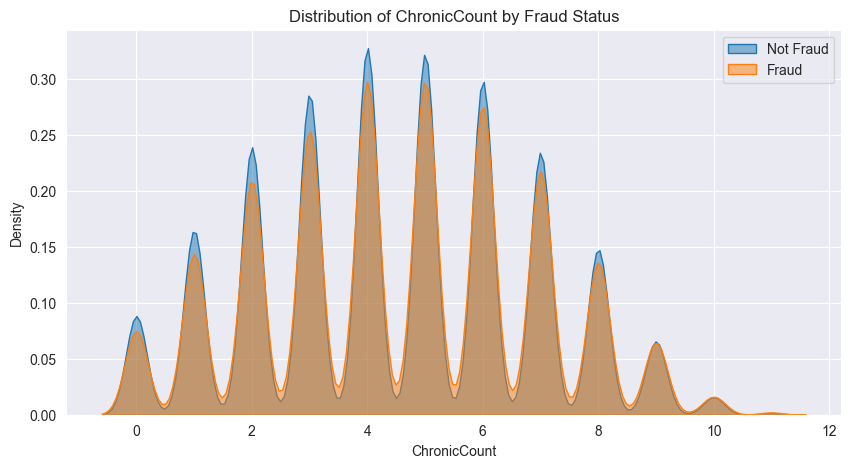

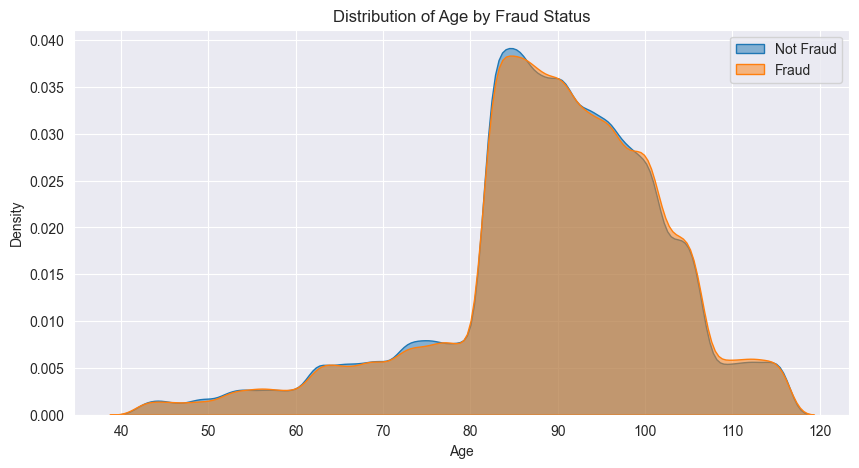

In [25]:
if "PotentialFraud" in train_data.columns:
    train_data["PotentialFraud"] = train_data["PotentialFraud"].map({"Yes": 1, "No": 0})

columns_to_plot = [
    "InscClaimAmtReimbursed",
    "DeductibleAmtPaid",
    "IPAnnualReimbursementAmt",
    "OPAnnualReimbursementAmt",
    "ChronicCount",
    "Age"
]

for col in columns_to_plot:
    plt.figure(figsize=(10, 5))

    sns.kdeplot(train_data[train_data["PotentialFraud"] == 0][col], label="Not Fraud", fill=True, alpha=0.5)
    sns.kdeplot(train_data[train_data["PotentialFraud"] == 1][col], label="Fraud", fill=True, alpha=0.5)

    plt.title(f"Distribution of {col} by Fraud Status")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()